## EVALUATION DU MODELE XGBOOST POUR PLUMENET
### Thierry

In [1]:
# Insatllation des packages
! pip install scikit-learn
! pip install xgboost
! pip install matplotlib


[notice] A new release of pip is available: 23.0.1 -> 24.1.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 24.1.1
[notice] To update, run: pip install --upgrade pip


In [2]:
# Import des librairies
import numpy as np
import pandas as pd
import os
from sklearn.model_selection import train_test_split, RandomizedSearchCV
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.decomposition import IncrementalPCA
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt

In [3]:
# Initialisation des variables d'environnement
plumnet_random_state=42

In [4]:
# Chargement des données
data_dir = 'french_bird_db'
dataset = 'french_bird_db_50_300'
dir_path = os.path.join('..',data_dir, dataset)
print(dir_path)

../french_bird_db/french_bird_db_50_300


../french_bird_db/french_bird_db_50_300/accipiter_gentilis/accipiter_gentilis_0.jpg


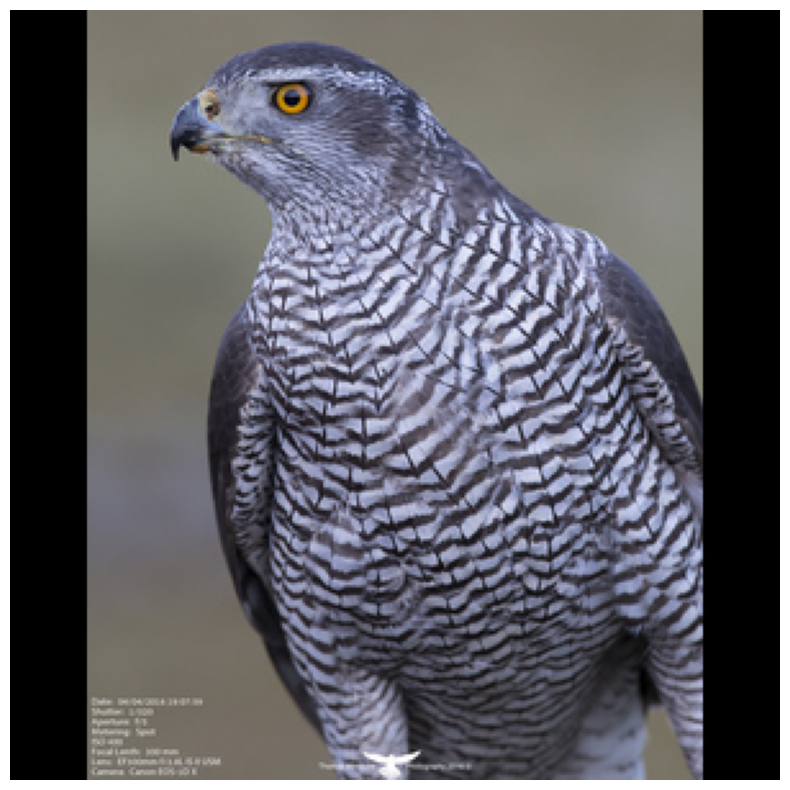

In [5]:
# Image de test
espece = 'accipiter_gentilis'
image_test = 'accipiter_gentilis_0.jpg'
file_path = os.path.join(dir_path, espece, image_test)
print(file_path)

img = plt.imread(file_path)
plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(img)
plt.show()

In [6]:
# Format des images
print(img.shape)

(300, 300, 3)


In [7]:
# ----------------------------------------------------- CHARGEMENT DU DATASET -------------------------------------------------------------

# Liste des répertoires = liste des espèces
repertoires = [nom for nom in os.listdir(dir_path) if os.path.isdir(os.path.join(dir_path, nom))]
repertoires = sorted(repertoires)

liste_images = []
liste_especes = []
X_constr = []
y_constr = []
espece_id = 0

nb_images = 0

# Récupération du nom des images
for repertoire in repertoires :
    liste_especes.append({'nom' : repertoire, 'id' : espece_id})
    dir_espece = os.path.join(dir_path, repertoire)
    #print(dir_espece)
    
    for fichier in os.listdir(dir_espece) :
            #print(fichier)
            nom_fichier = os.path.join(dir_espece, fichier)
            img = plt.imread(nom_fichier)
            img = img.reshape(-1)
            #print(img.shape[0])
            if (img.shape[0] == 300*300*3) :
                X_constr.append(nom_fichier)
                y_constr.append(espece_id)
    espece_id += 1
liste_especes = pd.DataFrame(liste_especes)

In [8]:
X_link = np.array(X_constr)
X_link.reshape(-1,1)
X_link.shape

(14968,)

In [9]:
y = np.array(y_constr)
y.reshape(-1,1)
print(y.shape)
print(y)

(14968,)
[ 0  0  0 ... 49 49 49]


In [10]:
#print(liste_especes)

In [11]:
# Split sur les liens
X_link_train, X_link_test, y_train, y_test = train_test_split(X_link, y, test_size=0.2, shuffle=True, random_state=plumnet_random_state)
print(X_link_train.shape, y_train.shape, X_link_test.shape, y_test.shape)

(11974,) (11974,) (2994,) (2994,)


In [12]:
# Instanciation du modèle incrementalPCA
pca_components = 150
ipca = IncrementalPCA(n_components=pca_components)

In [13]:
# Préparation des données pour un batch : chargement des images, reshape et PCA
def preparation (batch) : 
    # Chargement des images
    liste_images = []
        
    for index in range(len(batch)) :
        #print("Image", index)
        fic = batch[index]
        img = plt.imread(fic)

        # Reshape avec 270000 features
        img = img.reshape(-1)
        liste_images.append(img)

    X_processed = np.array(liste_images) 
    #print("Shape = ", X_processed)
    
    # Standardisation des données
    X_processed = X_processed / 255

    return X_processed

In [14]:
# Creation des batchs équilibrés avec stratified K-fold
# On découpe X_link_train en batchs qui contiennent toutes les classes
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html

batch_size = 300  # nombre d'images par batch
nb_batchs = int(np.ceil(X_link_train.shape[0] / batch_size)) #nombre batchs à faire tourner pour entrainer le modèle
print("nb_batchs = ", nb_batchs)
skf = StratifiedKFold(n_splits=nb_batchs, shuffle=True, random_state=plumnet_random_state)

# Boucle d'entrainement du PCA
i=0
for train_index, test_index in skf.split(X_link_train, y_train):
    i += 1
    X_batch = X_link_train[test_index]
    X_batch_processed = preparation(X_batch)
    if X_batch_processed.shape[0] >= pca_components :
        print("pca partiel ",i)
        ipca.partial_fit(X_batch_processed)

nb_batchs =  40
pca partiel
pca partiel
pca partiel
pca partiel
pca partiel
pca partiel
pca partiel
pca partiel
pca partiel
pca partiel
pca partiel
pca partiel
pca partiel
pca partiel
pca partiel
pca partiel
pca partiel
pca partiel
pca partiel
pca partiel
pca partiel
pca partiel
pca partiel
pca partiel
pca partiel
pca partiel
pca partiel
pca partiel
pca partiel
pca partiel
pca partiel
pca partiel
pca partiel
pca partiel
pca partiel
pca partiel
pca partiel
pca partiel
pca partiel
pca partiel


In [15]:
# Instanciation xgb incremental
# https://shunya-vichaar.medium.com/incremental-learning-in-xgboost-b3eac6135ce

# Définition des paramètres
params = {    
    'objective' : 'multi:softmax',
    'num_class' : len(liste_especes),
    'n_estimators' : 150,
    'max_depth' : 7,
    'eval_metric': 'merror',
    'eta': 0.3,
    'gamma' : 0,
    'reg_lambda': 1,
    'booster' : 'gbtree',
}
model = xgb.XGBClassifier(**params)

In [16]:
# Boucle fit incrémental du modèle XGB

batch_id = 0

for train_index, test_index in skf.split(X_link_train, y_train):
    print("batch ", batch_id)
    X_batch = X_link_train[test_index]
    X_batch_processed = preparation(X_batch)
    X_batch_processed = ipca.transform(X_batch_processed)
    y_batch = y_train[test_index]

    if batch_id == 0:
        #print("X shape ", X_batch_processed.shape,"y shape ", y_batch.shape)
        model = model.fit(X_batch_processed, y_batch)
    else:
        y_train_pred = model.predict(X_batch_processed)
        acc_train = accuracy_score(y_train_pred,y_batch)
        print("Accuracy train before = ", acc_train)
        model = model.fit(X_batch_processed, y_batch, xgb_model=model.get_booster())

    batch_id += 1

    
    y_train_pred = model.predict(X_batch_processed)
    acc_train = accuracy_score(y_train_pred,y_batch)
    print("Accuracy train after = ", acc_train)

batch  0
Accuracy train after =  1.0
batch  1
Accuracy train before =  0.03333333333333333
Accuracy train after =  1.0
batch  2
Accuracy train before =  0.04
Accuracy train after =  1.0
batch  3
Accuracy train before =  0.06333333333333334
Accuracy train after =  1.0
batch  4
Accuracy train before =  0.02666666666666667
Accuracy train after =  1.0
batch  5
Accuracy train before =  0.043333333333333335
Accuracy train after =  1.0
batch  6
Accuracy train before =  0.07333333333333333
Accuracy train after =  1.0
batch  7
Accuracy train before =  0.07
Accuracy train after =  1.0
batch  8
Accuracy train before =  0.07333333333333333
Accuracy train after =  0.9966666666666667
batch  9
Accuracy train before =  0.056666666666666664
Accuracy train after =  1.0
batch  10
Accuracy train before =  0.05333333333333334
Accuracy train after =  0.9966666666666667
batch  11
Accuracy train before =  0.03
Accuracy train after =  0.9966666666666667
batch  12
Accuracy train before =  0.056666666666666664
A

: 

In [1]:
# Calcul de l'accuracy
# Test
X_test_processed = preparation(X_link_test)
# on limite X_test/y_test
X_test_processed = X_test_processed[:200]
X_test_processed = ipca.transform(X_test_processed)
y_pred = model.predict(X_test_processed)
acc_test = accuracy_score(y_pred, y_test)
print("Accuracy test = ", acc_test)

#Train
y_train_pred = model.predict(X_batch_processed)
acc_train = accuracy_score(y_train_pred,y_batch)
print("Accuracy train = ", acc_train)

NameError: name 'preparation' is not defined